In [1]:
import copy
import os, sys
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_modelin import LinearRegression

ImportError: No module named 'seaborn'

In [3]:
df_path = "./data/processed/NYCQ_CCA_score_revision_yeo7nodes_4_0.8_0.5.pkl"

In [5]:
dataset = pd.read_pickle(df_path)

In [100]:
df_X = dataset.loc[:, 'CC_01':'CC_04']
df_Y = dataset.loc[:, 'DKEFSCWI_40':'WIAT_08']

In [134]:
X = df_X.drop('CC_01', axis=1)
Y = df_Y.drop('PROV_16', axis=1)
x = dataset['CC_01']
y = dataset['PROV_16']
dat = pd.concat((X, Y), axis=1)

In [ ]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [136]:
def fit_CI(x, y, dat):
    '''
    References:
    - Statistics in Geography by David Ebdon (ISBN: 978-0631136880)
    - Reliability Engineering Resource Website:
    - http://www.weibull.com/DOEWeb/confidence_intervals_in_simple_linear_regression.htm
    - University of Glascow, Department of Statistics:
    - http://www.stats.gla.ac.uk/steps/glossary/confidence_intervals.html#conflim
    '''
    # residualize
    lr = LinearRegression(fit_intercept=True)
    lr.fit(dat, x)
    x_res = x - lr.predict(dat)
    lr = LinearRegression(fit_intercept=True)
    lr.fit(dat, y)
    y_res = y - lr.predict(dat)
    
    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x_res, y_res, 1)
    p = np.poly1d(z)
    y_fit = p(x)
    print p
    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x) + 1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    n = len(x)              # number of samples in origional fit
    t = 1.96             # appropriate t value (two tailed 95%)
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/
                ((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))

    # now predict y based on test x-values
    p_y = z[0] * p_x + z[0]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    CI_lower = p_y - abs(confs)
    CI_upper = p_y + abs(confs)

    return y_fit, p_x, CI_lower, CI_upper

In [137]:
y_fit, p_x, CI_lower, CI_upper = fit_CI(x, y, dat)

 
0.2391 x + 1.382e-17


 
0.2391 x + 1.382e-17


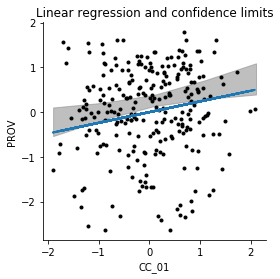

 
-0.198 x - 3.456e-18


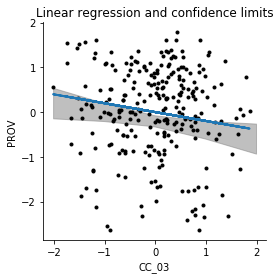

 
-0.01502 x + 1.382e-17


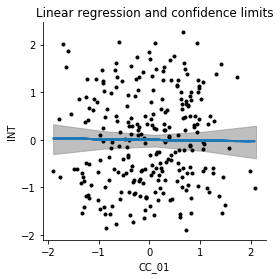

 
-0.04061 x + 1.382e-17


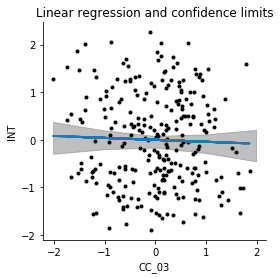

 
0.1502 x + 1.382e-17


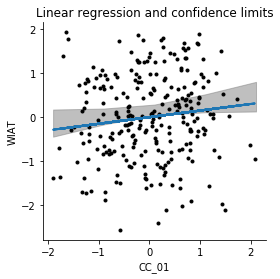

 
-0.1483 x - 4.147e-17


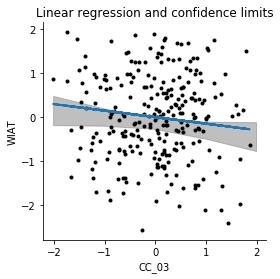

In [166]:
sig_sets = [
    ('CC_01', 'PROV_16'), 
    ('CC_03', 'PROV_16'),
    ('CC_01', 'INT_17'), 
    ('CC_03', 'INT_17'),    
    ('CC_01', 'WIAT_08'), 
    ('CC_03', 'WIAT_08'),
]

for s in sig_sets:
    x = dataset[s[0]]
    y = dataset[s[1]]
    X = df_X.drop(s[0], axis=1)
    Y = df_Y.drop(s[1], axis=1)
    dat = pd.concat((X, Y),axis=1)
    if s[0] == 'CC_03':
        x = - dataset[s[0]]

    y_fit, p_x, CI_lower, CI_upper = fit_CI(x, y, dat)

    plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    # set-up the plot
    plt.xlabel(s[0])
    plt.ylabel(s[1].split('_')[0])
    plt.title('Linear regression and confidence limits')

    # plot sample data
    ax.plot(x, y, '.k',label='Sample observations')

    # plot line of best fit
    ax.plot(x, y_fit, '-',label='Regression line', linewidth='2')

    # plot confidence limits
    ax.fill_between(p_x, CI_upper, CI_lower, color='grey', alpha=0.5, edgecolor=''
                     , label='95% Confidence Limits')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # show the plot
    plt.show()

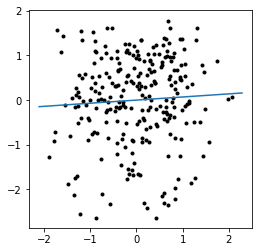

In [18]:
def scatter_plot_with_correlation_line(x, y, graph_filepath):
    '''
    http://stackoverflow.com/a/34571821/395857
    x does not have to be ordered.
    '''
    # stats
    m, b = np.polyfit(x, y, 1)
    y_model = np.polyval(m, x)
    
    # Scatter plot
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c='k', marker='.', vmin=-3, vmax=3)

    # Add correlation line
    axes = plt.gca()
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m * X_plot + b, '-')
    
    plt.fill_between
    
    
    # Save figure
    plt.show()
    # plt.savefig(graph_filepath, dpi=300, format='png', bbox_inches='tight')


scatter_plot_with_correlation_line(dataset['CC_01'], dataset['PROV_16'], 'scatter_plot.png')